In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


from sklearn import preprocessing
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


from sklearn.model_selection import StratifiedKFold


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

In [61]:
# Load the entire dataset into a pandas dataframe

df = pd.read_parquet('/nobackup/amimalik/bits/dataset/dimensions/4Q/working_dataset.parquet')
model_df = pd.read_csv('/nobackup/amimalik/bits/dataset/dimensions/4Q/sorted_failures.csv')

model_df = model_df.head(5)

In [62]:
df.shape

(469625, 13)

In [63]:
def group_by_serial_number(df, count):

    # Group the instances dataframe by serial number
    grouped_instances = df.groupby('serial_number')

    # Create an empty list to store the last 150 samples for each serial number
    last_n = []

    # Iterate over each group
    for name, group in grouped_instances:
        # Get the last n (count) samples for the current serial number
        last_n_group = group.tail(count)
        # Append the last n samples to the list
        last_n.append(last_n_group)

    # Concatenate the list of dataframes into a single dataframe
    instance_last_n = pd.concat(last_n)

    # Reset the index of the dataframe
    instance_last_n.reset_index(drop=True, inplace=True)

    # Drop the date column from the dataframe
    # instance_last_n.drop(columns=['date'], inplace=True)

    # reset index
    instance_last_n.reset_index(drop=True, inplace=True)
    
    # Print the updated dataframe
    # instance_last_n.head()

    return instance_last_n

In [64]:
ddf = group_by_serial_number(df, 30)
ddf.shape

(121664, 13)

In [65]:
ddf.to_parquet("/nobackup/amimalik/bits/dataset/dimensions/4Q/working_dataset_time.parquet")

In [66]:
def get_model_data(df, model):
    model_df = df[df['model'] == model]
    model_df = model_df.drop(columns=['model'])
    model_df.drop(columns=['serial_number'], inplace=True)
    return model_df


In [67]:
def get_clean_data(df):
    test = df.isnull().sum()
    d_col = []
    for k in test.keys():
        if test[k] == df.shape[0]:
            d_col.append(k)
    df.drop(columns=d_col, inplace=True)
    # replace null by mean values
    for col in df.columns:
        df[col].fillna(df[col].mean(), inplace=True)
    # reset index
    df.reset_index(drop=True, inplace=True)
    return df

In [76]:
def split_dataset(df):
    # Split the dataset into features (X) and target variable (y)
    X = df.drop(columns=['failure'])
    y = df['failure']

    # Split the dataset into train and test sets
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

    # Print the shape of the train and test sets
    print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

    train_y = np.array(train_y).reshape(-1, 1)
    test_y = np.array(test_y).reshape(-1, 1)

    # train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
    train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
    test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

    print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

    return train_X, train_y, test_X, test_y 

In [75]:
def model_fit(X_train, y_train, x_test, y_test, dev_model, epochs=50, batch_size=32, learning_rate=0.001):
    validation_number = int(0.9 * X_train.shape[0])
    validation_X = X_train[validation_number:]
    validation_y = y_train[validation_number:]
    train_X = X_train[:validation_number]
    train_y = y_train[:validation_number]


    # Define the model
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True, dropout=0.25))
    model.add(LSTM(50, return_sequences=False, dropout=0.25))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    # Fit the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(validation_X, validation_y), verbose=0)

    # summarize performance of the model
    scores = model.evaluate(train_X, train_y, verbose=0)
    # print(model.metrics_names)
    # print("model loss: %.2f%%" % (scores*100))

    # Use the trained model to predict on the test_X dataset
    predictions = model.predict(test_X)

    # Print the predictions
    # print(predictions)

    # Convert the predictions to binary values (0 or 1)
    binary_predictions = (predictions > 0.5).astype(int)

    # Calculate the evaluation metrics
    accuracy = accuracy_score(test_y, binary_predictions)
    precision = precision_score(test_y, binary_predictions)
    recall = recall_score(test_y, binary_predictions)
    f1 = f1_score(test_y, binary_predictions)
    roc_auc = roc_auc_score(test_y, binary_predictions)

    # Print the evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("ROC AUC score:", roc_auc)


    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('model accuracy for model: ' + dev_model)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    plt.show()

    return model

Model:  ST12000NM0008
(13694, 9) (3424, 9) (13694,) (3424,)
(13694, 1, 9) (3424, 1, 9) (13694, 1) (3424, 1)


/ws/amimalik-bgl/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
Accuracy: 0.9672897196261683
Precision: 0.0
Recall: 0.0
F1-score: 0.0
ROC AUC score: 0.4998490793842439


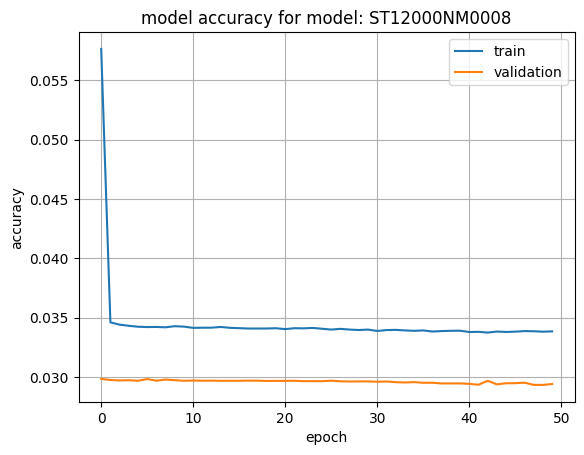

Model:  ST8000NM0055
(10416, 10) (2604, 10) (10416,) (2604,)
(10416, 1, 10) (2604, 1, 10) (10416, 1) (2604, 1)


/ws/amimalik-bgl/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.9623655913978495
Precision: 0.0
Recall: 0.0
F1-score: 0.0
ROC AUC score: 0.5


/ws/amimalik-bgl/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


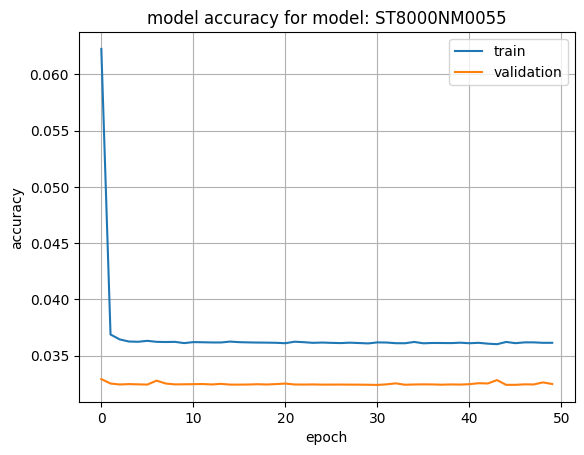

Model:  ST4000DM000
(10088, 10) (2522, 10) (10088,) (2522,)
(10088, 1, 10) (2522, 1, 10) (10088, 1) (2522, 1)


/ws/amimalik-bgl/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.964710547184774
Precision: 0.0
Recall: 0.0
F1-score: 0.0
ROC AUC score: 0.5


/ws/amimalik-bgl/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


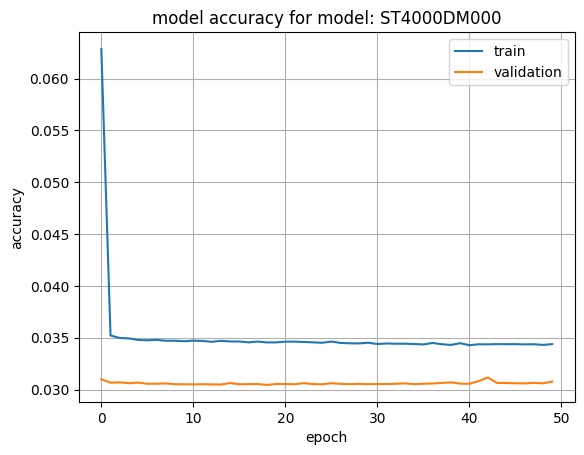

Model:  TOSHIBA MG07ACA14TA
(9400, 6) (2350, 6) (9400,) (2350,)
(9400, 1, 6) (2350, 1, 6) (9400, 1) (2350, 1)


/ws/amimalik-bgl/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.9629787234042553
Precision: 0.0
Recall: 0.0
F1-score: 0.0
ROC AUC score: 0.5


/ws/amimalik-bgl/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


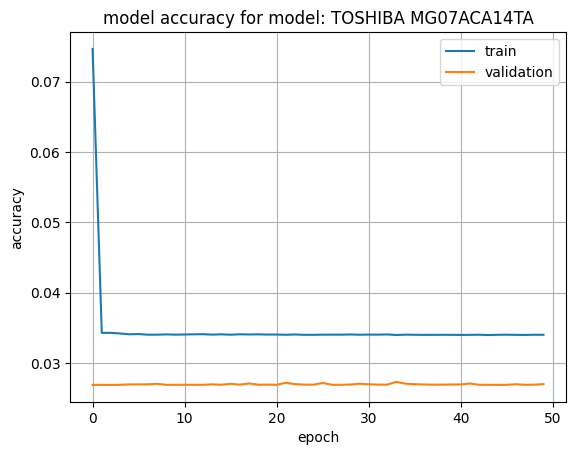

Model:  HGST HUH721212ALN604
(8332, 5) (2083, 5) (8332,) (2083,)
(8332, 1, 5) (2083, 1, 5) (8332, 1) (2083, 1)


/ws/amimalik-bgl/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.9615938550168027
Precision: 0.0
Recall: 0.0
F1-score: 0.0
ROC AUC score: 0.5


/ws/amimalik-bgl/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


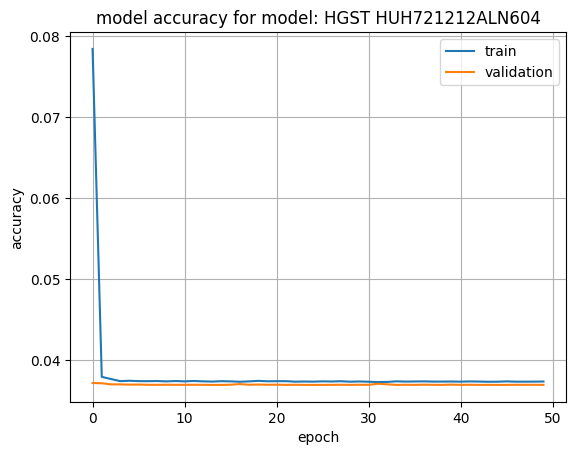

In [77]:
for dev_models in model_df['model']:
    model_data = get_model_data(ddf, dev_models)
    model_data = get_clean_data(model_data)
    fold_count = 0
    print ("Model: ", dev_models)

    train_X, train_y, test_X, test_y = split_dataset(model_data)
    model_fit(train_X, train_y, test_X, test_y, epochs=50, batch_size=32, learning_rate=0.001, dev_model=dev_models)


In [70]:
dev_models = 'ST12000NM0008'
model_data = get_model_data(ddf, dev_models)
model_data = get_clean_data(model_data)

In [71]:
model_data.shape

(17118, 10)

(13694, 9) (3424, 9) (13694,) (3424,)
(13694, 1, 9) (3424, 1, 9) (13694, 1) (3424, 1)


/ws/amimalik-bgl/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.9675817757009346
Precision: 0.0
Recall: 0.0
F1-score: 0.0
ROC AUC score: 0.5


/ws/amimalik-bgl/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


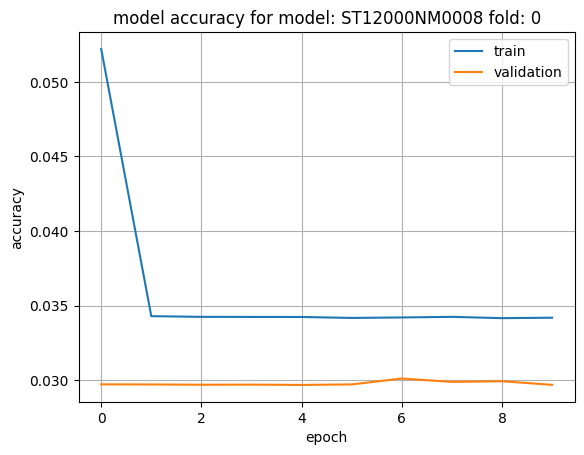

<Sequential name=sequential_2, built=True>

In [72]:
train_X, train_y, test_X, test_y = split_dataset(model_data)
model_fit(train_X, train_y, test_X, test_y, epochs=10, batch_size=32, learning_rate=0.001, dev_model=dev_models, fold_count=0)